<a href="https://colab.research.google.com/github/450586509/practical-ml/blob/master/wide_deep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Wide and Deep Model for Movie Recommendation

A linear model with a wide set of crossed-column (co-occurrence) features can memorize the feature interactions, while deep neural networks (DNN) can generalize the feature patterns through low-dimensional dense embeddings learned for the sparse features. Wide-and-deep learning jointly trains wide linear model and deep neural networks to combine the benefits of memorization and generalization for recommender systems.

This notebook shows how to build and test the wide-and-deep model using TensorFlow high-level Estimator API. With the movie recommendation dataset, we quickly demonstrate following topics:

How to prepare data
Build the model
Use log-hook to estimate performance while training
Test the model and export

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!pip install scrapbook
!pip install recommenders

     |████████████████████████████████| 130 kB 4.6 MB/s 
     |████████████████████████████████| 428 kB 67.3 MB/s 
  Attempting uninstall: tornado
    Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires tornado~=5.1.0; python_version >= "3.0", but you have tornado 6.1 which is incompatible.


     |████████████████████████████████| 335 kB 33.8 MB/s 
     |████████████████████████████████| 197 kB 63.3 MB/s 
     |████████████████████████████████| 11.8 MB 64.0 MB/s 
     |████████████████████████████████| 61 kB 9.7 MB/s 
     |████████████████████████████████| 310 kB 52.3 MB/s 
     |████████████████████████████████| 636 kB 48.3 MB/s 
     |████████████████████████████████| 1.5 MB 43.9 MB/s 
     |████████████████████████████████| 12.4 MB 24.3 MB/s 
     |████████████████████████████████| 4.0 MB 52.1 MB/s 
     |████████████████████████████████| 749 kB 42.7 MB/s 
     |████████████████████████████████| 10.9 MB 50.3 MB/s 
     |████████████████████████████████| 383 kB 62.8 MB/s 
     |████████████████████████████████| 880 kB 55.5 MB/s 
     |████████████████████████████████| 6.6 MB 52.1 MB/s 
     |████████████████████████████████| 77 kB 9.8 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705374 sha256=7841e0333e969f12dd6f75d83d442975c

In [3]:
import itertools
import math
import os
from tempfile import TemporaryDirectory

import numpy as np
import scrapbook as sb
import pandas as pd
import sklearn.preprocessing
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.utils.constants import (
    DEFAULT_USER_COL as USER_COL,
    DEFAULT_ITEM_COL as ITEM_COL,
    DEFAULT_RATING_COL as RATING_COL,
    DEFAULT_PREDICTION_COL as PREDICT_COL,
    DEFAULT_GENRE_COL as ITEM_FEAT_COL,
    SEED
)
from recommenders.utils import tf_utils, gpu_utils, plot
from recommenders.datasets import movielens
from recommenders.datasets.pandas_df_utils import user_item_pairs
from recommenders.datasets.python_splitters import python_random_split
import recommenders.evaluation.python_evaluation as evaluator
import recommenders.models.wide_deep.wide_deep_utils as wide_deep

print("Tensorflow Version:", tf.__version__)
print("GPUs:\n", gpu_utils.get_gpu_info())

[autoreload of jupyter_client failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name 'ZMQSocketChannel' from 'jupyter_client.channels' (/usr/local/lib/python3.7/dist-packages/jupyter_client/channels.py)
]
[autoreload of jupyter_client.manager failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ValueError: _launch_kernel() requires a code object with 0 free vars, not 1
]
[autoreload of jupyter_client.blocking.client failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ValueError: wait_for_ready() requires a code object with 0 free vars, not 1
]
[autoreload

Tensorflow Version: 2.8.0
GPUs:
 [{'device_name': 'Tesla T4', 'total_memory': 15109.75, 'free_memory': 15007.75}]


/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


In [4]:
"""Parameters (papermill)"""

# Recommend top k items
TOP_K = 10
# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '100k'
# Metrics to use for evaluation
RANKING_METRICS = [
    evaluator.ndcg_at_k.__name__,
    evaluator.precision_at_k.__name__,
]
RATING_METRICS = [
    evaluator.rmse.__name__,
    evaluator.mae.__name__,
]
# Use session hook to evaluate model while training
EVALUATE_WHILE_TRAINING = True

RANDOM_SEED = SEED  # Set seed for deterministic result

# Train and test set pickle file paths. If provided, use them. Otherwise, download the MovieLens dataset.
DATA_DIR = None
TRAIN_PICKLE_PATH = None
TEST_PICKLE_PATH = None
EXPORT_DIR_BASE = './outputs/model'
# Model checkpoints directory. If None, use temp-dir.
MODEL_DIR = None

/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


In [5]:
#### Hyperparameters
MODEL_TYPE = 'wide_deep'
STEPS = 50000  # Number of batches to train
BATCH_SIZE = 32
# Wide (linear) model hyperparameters
LINEAR_OPTIMIZER = 'adagrad'
LINEAR_OPTIMIZER_LR = 0.0621  # Learning rate
LINEAR_L1_REG = 0.0           # Regularization rate for FtrlOptimizer
LINEAR_L2_REG = 0.0
LINEAR_MOMENTUM = 0.0         # Momentum for MomentumOptimizer or RMSPropOptimizer
# DNN model hyperparameters
DNN_OPTIMIZER = 'adadelta'
DNN_OPTIMIZER_LR = 0.1
DNN_L1_REG = 0.0           # Regularization rate for FtrlOptimizer
DNN_L2_REG = 0.0
DNN_MOMENTUM = 0.0         # Momentum for MomentumOptimizer or RMSPropOptimizer
# Layer dimensions. Defined as follows to make this notebook runnable from Hyperparameter tuning services like AzureML Hyperdrive
DNN_HIDDEN_LAYER_1 = 0     # Set 0 to not use this layer
DNN_HIDDEN_LAYER_2 = 64    # Set 0 to not use this layer
DNN_HIDDEN_LAYER_3 = 128   # Set 0 to not use this layer
DNN_HIDDEN_LAYER_4 = 512   # Note, at least one layer should have nodes.
DNN_HIDDEN_UNITS = [h for h in [DNN_HIDDEN_LAYER_1, DNN_HIDDEN_LAYER_2, DNN_HIDDEN_LAYER_3, DNN_HIDDEN_LAYER_4] if h > 0]
DNN_USER_DIM = 32          # User embedding feature dimension
DNN_ITEM_DIM = 16          # Item embedding feature dimension
DNN_DROPOUT = 0.8
DNN_BATCH_NORM = 1         # 1 to use batch normalization, 0 if not.


/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


In [6]:
if MODEL_DIR is None:
    TMP_DIR = TemporaryDirectory()
    model_dir = TMP_DIR.name
else:
    if os.path.exists(MODEL_DIR) and os.listdir(MODEL_DIR):
        raise ValueError(
            "Model exists in {}. Use different directory name or "
            "remove the existing checkpoint files first".format(MODEL_DIR)
        )
    TMP_DIR = None
    model_dir = MODEL_DIR

/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


### 1. Prepare Data
1.1 Movie Rating and Genres Data

First, download MovieLens data. 
Movies in the data set are tagged as one or more genres where there are total 19 genres including 'unknown'. We load movie genres to use them as item features.

In [7]:
use_preset = (TRAIN_PICKLE_PATH is not None and TEST_PICKLE_PATH is not None)
if not use_preset:
    # The genres of each movie are returned as '|' separated string, e.g. "Animation|Children's|Comedy".
    data = movielens.load_pandas_df(
        size=MOVIELENS_DATA_SIZE,
        header=[USER_COL, ITEM_COL, RATING_COL],
        genres_col=ITEM_FEAT_COL
    )
    display(data.head())

  0%|          | 0.00/4.81k [00:00<?, ?KB/s]/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)
100%|██████████| 4.81k/4.81k [00:01<00:00, 2.62kKB/s]


,userID,itemID,rating,genre
0,196,242,3.0,Comedy
1,63,242,3.0,Comedy
2,226,242,5.0,Comedy
3,154,242,3.0,Comedy
4,306,242,5.0,Comedy


/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


### 1.2 Encode Item Features (Genres)

离散的类型特征向量化。

To use genres from our model, we multi-hot-encode them with scikit-learn's MultiLabelBinarizer.


For example, Movie id=2355 has three genres, Animation|Children's|Comedy, which are being converted into an integer array of the indicator value for each genre like [0, 0, 1, 1, 1, 0, 0, 0, ...]. In the later step, we convert this into a float array and feed into the model.


For faster feature encoding, you may load ratings and items separately (by using movielens.load_item_df), encode the item-features, then combine the rating and item dataframes by using join-operation.

In [8]:
if not use_preset and ITEM_FEAT_COL is not None:
    # Encode 'genres' into int array (multi-hot representation) to use as item features
    genres_encoder = sklearn.preprocessing.MultiLabelBinarizer()
    data[ITEM_FEAT_COL] = genres_encoder.fit_transform(
        data[ITEM_FEAT_COL].apply(lambda s: s.split("|"))
    ).tolist()
    print("Genres:", genres_encoder.classes_)
    display(data.head())

Genres: ['Action' 'Adventure' 'Animation' "Children's" 'Comedy' 'Crime'
 'Documentary' 'Drama' 'Fantasy' 'Film-Noir' 'Horror' 'Musical' 'Mystery'
 'Romance' 'Sci-Fi' 'Thriller' 'War' 'Western' 'unknown']


/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


,userID,itemID,rating,genre
0,196,242,3.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,63,242,3.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,226,242,5.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,154,242,3.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,306,242,5.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### 1.3 Train and Test Split


In [9]:
if not use_preset:
    train, test = python_random_split(data, ratio=0.75, seed=RANDOM_SEED)
else:
    train = pd.read_pickle(path=TRAIN_PICKLE_PATH if DATA_DIR is None else os.path.join(DATA_DIR, TRAIN_PICKLE_PATH))
    test = pd.read_pickle(path=TEST_PICKLE_PATH if DATA_DIR is None else os.path.join(DATA_DIR, TEST_PICKLE_PATH))
    data = pd.concat([train, test])

print("{} train samples and {} test samples".format(len(train), len(test)))

75000 train samples and 25000 test samples


/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


In [21]:
print(users)

     userID
0       196
1        63
2       226
3       154
4       306
..      ...
938     799
939     358
940     410
941     598
942     873

[943 rows x 1 columns]


/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


In [10]:
# Unique items in the dataset
if ITEM_FEAT_COL is None:
    items = data.drop_duplicates(ITEM_COL)[[ITEM_COL]].reset_index(drop=True)
    item_feat_shape = None
else:
    items = data.drop_duplicates(ITEM_COL)[[ITEM_COL, ITEM_FEAT_COL]].reset_index(drop=True)
    item_feat_shape = len(items[ITEM_FEAT_COL][0])
# Unique users in the dataset
users = data.drop_duplicates(USER_COL)[[USER_COL]].reset_index(drop=True)

print("Total {} items and {} users in the dataset".format(len(items), len(users)))

Total 1682 items and 943 users in the dataset


/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


## 2. Build Model


Wide-and-deep model consists of a linear model and DNN. We use the following hyperparameters and feature sets for the model:



Note, the hyperparameters are optimized for the training set. We used Azure Machine Learning service (AzureML) to find the best hyperparameters, where we further split the training set into two subsets for training and validation respectively so that the test set is being separated from the tuning and training phases. For more details, see azureml_hyperdrive_wide_and_deep.ipynb.

In [11]:
# Create model checkpoint every n steps. We store the model 5 times.
save_checkpoints_steps = max(1, STEPS // 5)

/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


In [25]:
print(f"users={users}")
print(f"items={items}")
print(f"item_feat_shape={item_feat_shape}")
print(f"MODEL_TYPE={MODEL_TYPE}")
print(f"DNN_USER_DIM={DNN_USER_DIM}")
print(f"DNN_ITEM_DIM={DNN_ITEM_DIM}")

users=     userID
0       196
1        63
2       226
3       154
4       306
..      ...
938     799
939     358
940     410
941     598
942     873

[943 rows x 1 columns]
items=      itemID                                              genre
0        242  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1        302  [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...
2        377  [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3         51  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...
4        346  [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
...      ...                                                ...
1677    1674  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
1678    1640  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
1679    1637  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
1680    1630  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
1681    1641  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...

[1682 rows x 2 columns]
item_feat_shape=19
MODEL_TY

/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


In [26]:
# Define wide (linear) and deep (dnn) features
wide_columns, deep_columns = wide_deep.build_feature_columns(
    users=users[USER_COL].values,
    items=items[ITEM_COL].values,
    user_col=USER_COL,
    item_col=ITEM_COL,
    item_feat_col=ITEM_FEAT_COL,
    crossed_feat_dim=1000,
    user_dim=DNN_USER_DIM,
    item_dim=DNN_ITEM_DIM,
    item_feat_shape=item_feat_shape,
    model_type=MODEL_TYPE,
)

print("Wide feature specs:")
for c in wide_columns:
    print("\t", str(c)[:200], "...")
print("Deep feature specs:")
for c in deep_columns:
    print("\t", str(c)[:200], "...")

Wide feature specs:
	 VocabularyListCategoricalColumn(key='userID', vocabulary_list=(196, 63, 226, 154, 306, 296, 34, 271, 201, 209, 35, 354, 199, 113, 1, 173, 360, 234, 14, 309, 331, 21, 111, 439, 355, 204, 145, 30, 463,  ...
	 VocabularyListCategoricalColumn(key='itemID', vocabulary_list=(242, 302, 377, 51, 346, 474, 265, 465, 451, 86, 257, 1014, 222, 40, 29, 785, 387, 274, 1042, 1184, 392, 486, 144, 118, 1, 546, 95, 768, 2 ...
	 CrossedColumn(keys=(VocabularyListCategoricalColumn(key='userID', vocabulary_list=(196, 63, 226, 154, 306, 296, 34, 271, 201, 209, 35, 354, 199, 113, 1, 173, 360, 234, 14, 309, 331, 21, 111, 439, 355, ...
Deep feature specs:
	 EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='userID', vocabulary_list=(196, 63, 226, 154, 306, 296, 34, 271, 201, 209, 35, 354, 199, 113, 1, 173, 360, 234, 14, 309, 331, 21, ...
	 EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='itemID', vocabulary_list=(242, 302, 377, 51, 346, 474, 265

/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


In [27]:
print(f"model_dir={model_dir}")

model_dir=/tmp/tmpcvafdtqw


/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


In [13]:
# Build a model based on the parameters
model = wide_deep.build_model(
    model_dir=model_dir,
    wide_columns=wide_columns,
    deep_columns=deep_columns,
    linear_optimizer=tf_utils.build_optimizer(LINEAR_OPTIMIZER, LINEAR_OPTIMIZER_LR, **{
        'l1_regularization_strength': LINEAR_L1_REG,
        'l2_regularization_strength': LINEAR_L2_REG,
        'momentum': LINEAR_MOMENTUM,
    }),
    dnn_optimizer=tf_utils.build_optimizer(DNN_OPTIMIZER, DNN_OPTIMIZER_LR, **{
        'l1_regularization_strength': DNN_L1_REG,
        'l2_regularization_strength': DNN_L2_REG,
        'momentum': DNN_MOMENTUM,  
    }),
    dnn_hidden_units=DNN_HIDDEN_UNITS,
    dnn_dropout=DNN_DROPOUT,
    dnn_batch_norm=(DNN_BATCH_NORM==1),
    log_every_n_iter=max(1, STEPS//10),  # log 10 times
    save_checkpoints_steps=save_checkpoints_steps,
    seed=RANDOM_SEED
)

/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


### 3. Train and Evaluate Model


Now we are all set to train the model. Here, we show how to utilize session hooks to track model performance while training. Our custom hook tf_utils.evaluation_log_hook estimates the model performance on the given data based on the specified evaluation functions. Note we pass test set to evaluate the model on rating metrics while we use ranking-pool (all the user-item pairs) for ranking metrics.

Note: The TensorFlow Estimator's default loss calculates Mean Squared Error. Square root of the loss is the same as RMSE.



In [14]:
cols = {
    'col_user': USER_COL,
    'col_item': ITEM_COL,
    'col_rating': RATING_COL,
    'col_prediction': PREDICT_COL,
}

# Prepare ranking evaluation set, i.e. get the cross join of all user-item pairs
ranking_pool = user_item_pairs(
    user_df=users,
    item_df=items,
    user_col=USER_COL,
    item_col=ITEM_COL,
    user_item_filter_df=train,  # Remove seen items
    shuffle=True,
    seed=RANDOM_SEED
)


/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


In [15]:
# Define training hooks to track performance while training
hooks = []
if EVALUATE_WHILE_TRAINING:
    evaluation_logger = tf_utils.MetricsLogger()
    for metrics in (RANKING_METRICS, RATING_METRICS):
        if len(metrics) > 0:
            hooks.append(
                tf_utils.evaluation_log_hook(
                    model,
                    logger=evaluation_logger,
                    true_df=test,
                    y_col=RATING_COL,
                    eval_df=ranking_pool if metrics==RANKING_METRICS else test.drop(RATING_COL, axis=1),
                    every_n_iter=save_checkpoints_steps,
                    model_dir=model_dir,
                    eval_fns=[evaluator.metrics[m] for m in metrics],
                    **({**cols, 'k': TOP_K} if metrics==RANKING_METRICS else cols)
                )
            )
# Define training input (sample feeding) function
train_fn = tf_utils.pandas_input_fn(
    df=train,
    y_col=RATING_COL,
    batch_size=BATCH_SIZE,
    num_epochs=None,  # We use steps=TRAIN_STEPS instead.
    shuffle=True,
    seed=RANDOM_SEED,
)

/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


In [16]:
print(
    "Training steps = {}, Batch size = {} (num epochs = {})"
    .format(STEPS, BATCH_SIZE, (STEPS*BATCH_SIZE)//len(train))
)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)

try:
    model.train(
        input_fn=train_fn,
        hooks=hooks,
        steps=STEPS
    )
except tf.train.NanLossDuringTrainingError:
    import warnings
    warnings.warn(
        "Training stopped with NanLossDuringTrainingError. "
        "Try other optimizers, smaller batch size and/or smaller learning rate."
    )

Training steps = 50000, Batch size = 32 (num epochs = 21)
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


INFO:tensorflow:Calling model_fn.
Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpcvafdtqw/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 432.8184, step = 0


/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


INFO:tensorflow:global_step/sec: 44.3512
INFO:tensorflow:loss = 37.709858, step = 5000 (54.197 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 10000...
INFO:tensorflow:Saving checkpoints for 10000 into /tmp/tmpcvafdtqw/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 10000...
INFO:tensorflow:global_step/sec: 92.8168


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:loss = 18.668127, step = 10000 (101.118 sec)


/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


INFO:tensorflow:global_step/sec: 49.6343
INFO:tensorflow:loss = 19.748404, step = 15000 (53.488 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 20000...
INFO:tensorflow:Saving checkpoints for 20000 into /tmp/tmpcvafdtqw/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 20000...
INFO:tensorflow:global_step/sec: 95.2084


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:loss = 37.013844, step = 20000 (100.119 sec)


/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


INFO:tensorflow:global_step/sec: 50.1501
INFO:tensorflow:loss = 27.604053, step = 25000 (52.102 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 30000...
INFO:tensorflow:Saving checkpoints for 30000 into /tmp/tmpcvafdtqw/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 30000...
INFO:tensorflow:global_step/sec: 95.8428


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:loss = 28.62111, step = 30000 (100.548 sec)


/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


INFO:tensorflow:global_step/sec: 49.7838
INFO:tensorflow:loss = 28.663324, step = 35000 (52.051 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 40000...
INFO:tensorflow:Saving checkpoints for 40000 into /tmp/tmpcvafdtqw/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 40000...
INFO:tensorflow:global_step/sec: 95.1219


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:loss = 25.6828, step = 40000 (100.755 sec)


/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


INFO:tensorflow:global_step/sec: 47.7248
INFO:tensorflow:loss = 21.718578, step = 45000 (56.575 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 50000...
INFO:tensorflow:Saving checkpoints for 50000 into /tmp/tmpcvafdtqw/model.ckpt.
Instructions for updating:
Use standard file APIs to delete files with this prefix.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 50000...
INFO:tensorflow:Loss for final step: 23.884945.


/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


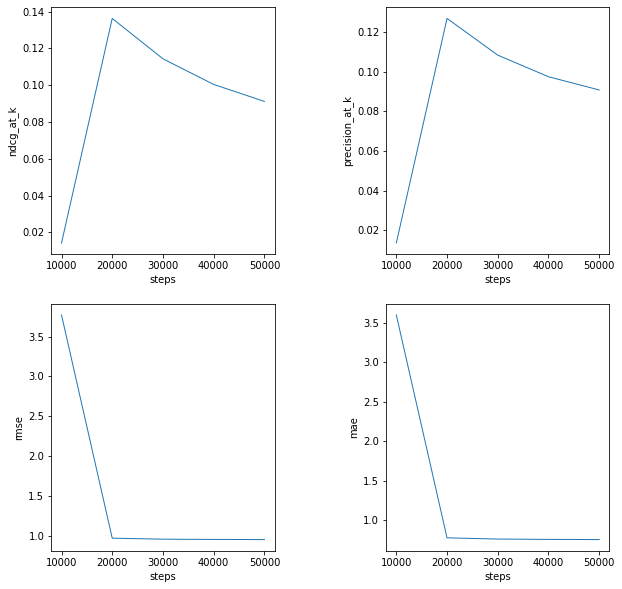

In [17]:
if EVALUATE_WHILE_TRAINING:
    logs = evaluation_logger.get_log()
    for i, (m, v) in enumerate(logs.items(), 1):
        sb.glue("eval_{}".format(m), v)
        x = [save_checkpoints_steps*i for i in range(1, len(v)+1)]
        plot.line_graph(
            values=list(zip(v, x)),
            labels=m,
            x_name="steps",
            y_name=m,
            subplot=(math.ceil(len(logs)/2), 2, i),
        )

### Test and Export Model

4.1 Item rating prediction


In [18]:
if len(RATING_METRICS) > 0:
    predictions = list(model.predict(input_fn=tf_utils.pandas_input_fn(df=test)))
    prediction_df = test.drop(RATING_COL, axis=1)
    prediction_df[PREDICT_COL] = [p['predictions'][0] for p in predictions]
    
    rating_results = {}
    for m in RATING_METRICS:
        result = evaluator.metrics[m](test, prediction_df, **cols)
        sb.glue(m, result)
        rating_results[m] = result
    print(rating_results)

INFO:tensorflow:Calling model_fn.


/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


INFO:tensorflow:Done calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpcvafdtqw/model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


{'rmse': 0.9526225781537487, 'mae': 0.7576765909850597}


/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


## 4.2 Recommend k items


For top-k recommendation evaluation, we use the ranking pool (all the user-item pairs) we prepared at the training step. The difference is we remove users' seen items from the pool in this step which is more natural to the movie recommendation scenario.



In [19]:
if len(RANKING_METRICS) > 0:
    predictions = list(model.predict(input_fn=tf_utils.pandas_input_fn(df=ranking_pool)))
    prediction_df = ranking_pool.copy()
    prediction_df[PREDICT_COL] = [p['predictions'][0] for p in predictions]

    ranking_results = {}
    for m in RANKING_METRICS:
        result = evaluator.metrics[m](test, prediction_df, **{**cols, 'k': TOP_K})
        sb.glue(m, result)
        ranking_results[m] = result
    print(ranking_results)

INFO:tensorflow:Calling model_fn.


/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)
/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpcvafdtqw/model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


{'ndcg_at_k': 0.08610482100038545, 'precision_at_k': 0.08589607635206789}


## 4.3 Export Model


Finally, we export the model so that we can load later for re-training, evaluation, and prediction. Examples of how to load, re-train, and evaluate the saved model can be found from azureml_hyperdrive_wide_and_deep.ipynb notebook.

In [20]:
os.makedirs(EXPORT_DIR_BASE, exist_ok=True)
exported_path = tf_utils.export_model(
    model=model,
    train_input_fn=train_fn,
    eval_input_fn=tf_utils.pandas_input_fn(
        df=test, y_col=RATING_COL
    ),
    tf_feat_cols=wide_columns+deep_columns,
    base_dir=EXPORT_DIR_BASE
)
sb.glue('saved_model_dir', str(exported_path))
print("Model exported to", str(exported_path))


# Close the event file so that the model folder can be cleaned up.
summary_writer = tf.compat.v1.summary.FileWriterCache.get(model.model_dir)
summary_writer.close()

# Cleanup temporary directory if used
if TMP_DIR is not None:
    TMP_DIR.cleanup()

/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)
/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


Model exported to ./outputs/model/1652179129
